In [ ]:
import mne
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

# Load and preprocess data
As this exercise is concerned with visualising and interpreting, we will not go into detail about how to load and preprocess the data. For more information about how to load and preprocess data, please refer to the EEG analysis tutorial from the EEG lab. 

That is, just use the following code to load and do minimal preprocessing on the data and create epochs.

**Note:** Remember to pip install mne if you haven't already using the command `pip install mne`.

In [ ]:
# reading the file & loading in the data
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file) # raw is an MNE object that contains the data of the class Raw
raw.load_data()

# PREPROCESSING
# pick only EEG
raw.pick_types(meg=False, eeg=True, stim=True, exclude='bads')

# common average reference (CAR)
raw.set_eeg_reference(ref_channels='average')

# high and low-pass filtering
raw = raw.filter(0.1, None)
raw = raw.filter(None, 40)

# EPOCHING
events = mne.find_events(raw, stim_channel='STI 014')
event_id = {'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3,
            'visual/right': 4, 'smiley': 5, 'buttonpress': 32} 

tmin, tmax = -0.2, 0.5
baseline = (None, 0)
reject = dict(eeg=100e-6)

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, 
                    baseline=baseline, reject=reject, preload=True)

# resampling to 250 Hz
epochs.resample(250)

Opening raw data file /Users/laurapaulsen/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband atten

Number of events,281
Events,auditory/left: 59auditory/right: 65buttonpress: 15smiley: 14visual/left: 69visual/right: 59
Time range,-0.200 – 0.496 sec
Baseline,-0.200 – 0.000 sec


# Visualisation exercise
The goal of this exercise is to create visualisations of the EEG data to support or refute interpretations of the data. You will be provided with three interpretations, and your task is to create visualisations that support or refute these interpretations.

## Interpretation 1

The standard deviation of the EEG signal across channels is higher for the visual condition than for the auditory condition in the 250-400 ms time window after stimulus onset. However, the standard deviation of the EEG signal across channels is lower for the visual condition than for the auditory condition in the 50-150 ms time window after stimulus onset.

combining channels using "gfp"
combining channels using "gfp"


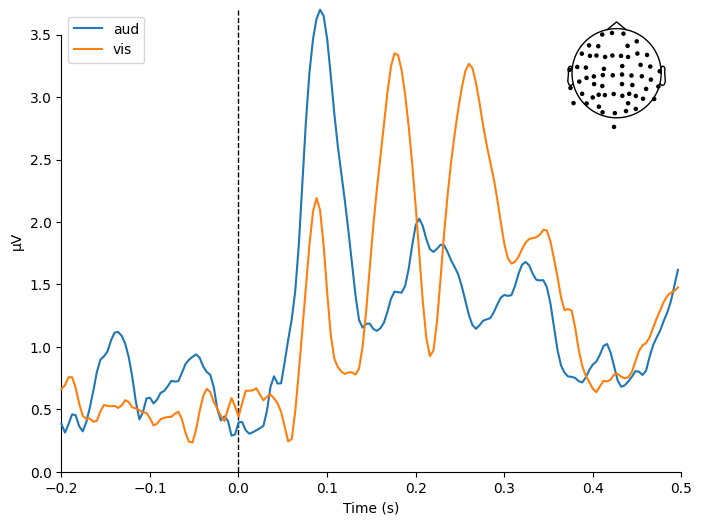

No projector specified for this dataset. Please consider the method self.add_proj.


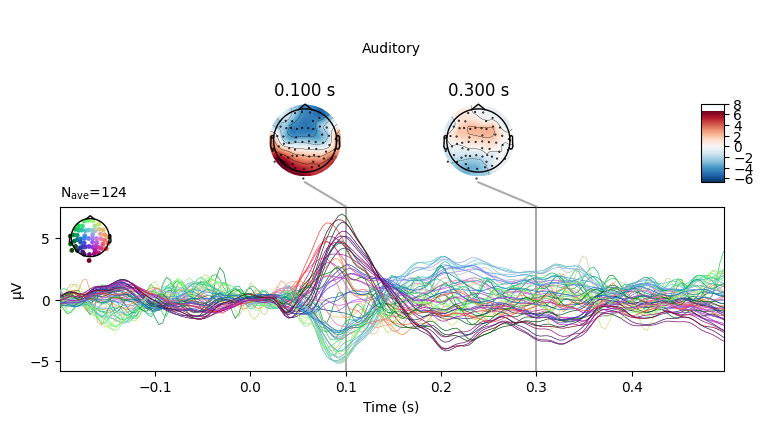

No projector specified for this dataset. Please consider the method self.add_proj.


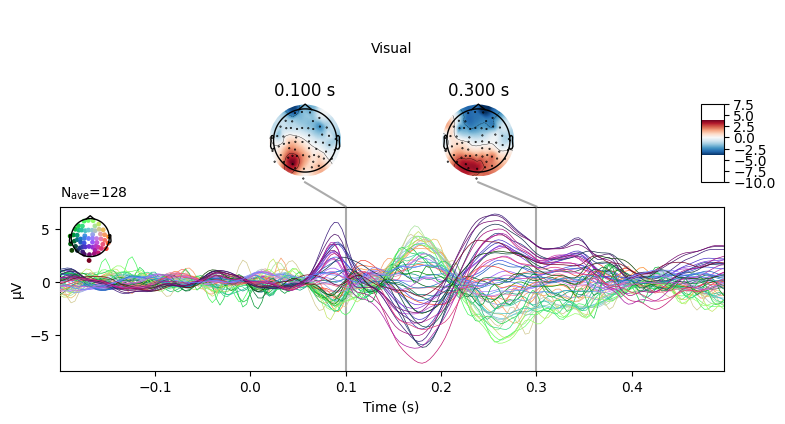

In [110]:
aud = epochs['auditory'].average()
vis = epochs['visual'].average()

# compare evoked responses
mne.viz.plot_compare_evokeds(dict(aud=aud, vis=vis), show_sensors='upper right');


aud.plot_joint(title='Auditory', times=[0.1, 0.3]);
vis.plot_joint(title='Visual', times=[0.1, 0.3]);

**Thinking exercise:** Was the interpretation correct? Why or why not? How could you conduct a statistical test to determine whether the interpretation is correct?

## Interpretation 2
When a visual stimuli is presented to left visual field, the signal in over the contra-lateral hemisphere is higher than the signal over the ipsi-lateral hemisphere. When a visual stimuli is presented, the signal over the ipsi-lateral hemisphere is higher than the signal over the contra-lateral hemisphere from 50 to 100 ms after presentation.

**Hint:** Use the following code to plot the location of the electrodes on the scalp to help you identify the contra- and ipsi-lateral channels.

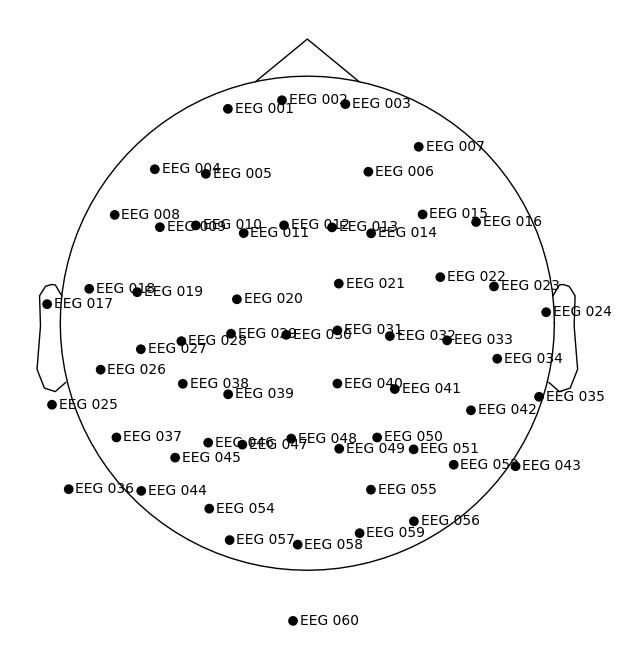

In [111]:
# plot the locations of the sensors
mne.viz.plot_sensors(raw.info, show_names=True);

**Hint 2:** Here is some code for investigating the same but for the auditory condition rather than visual.

In [112]:
def contra_ipsi_plot(epochs, contra_ch:list, ipsi_ch:list, title:str, timepoints:list):
    """
    Plots the evoked response of contra and ipsi channels.

    Parameters
    ----------
    epochs : mne.Epochs
        The epochs object only including trials with stimulus presented to one side.
    contra_ch : list
        The list of contra-lateral channels.
    ipsi_ch : list
        The list of ipsi-lateral channels.
    title : str
        The title of the plot.
    timepoints : list
        The timepoints to plot a vertical line at.
    """
    # epochs
    epochs_ipsi = epochs.copy().pick_channels(ipsi_ch)
    epochs_contra = epochs.copy().pick_channels(contra_ch)

    evoked_ipsi_ch = epochs_ipsi.get_data().mean(axis=(0, 1))
    evoked_contra_ch = epochs_contra.get_data().mean(axis=(0, 1))
    
        # plot the evoked responses
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)

    # plot the evoked responses
    ax.plot(epochs_ipsi.times, evoked_ipsi_ch, color='g', label='ipsilateral channels')
    ax.plot(epochs_contra.times, evoked_contra_ch, color='b', label='contralateral channels')
    ax.set(title=title, xlabel='Time (s)', ylabel='Amplitude (V)')
    ax.legend()

    # plot the timepoints
    for timepoint in timepoints:
        ax.axvline(timepoint, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
    plt.show()



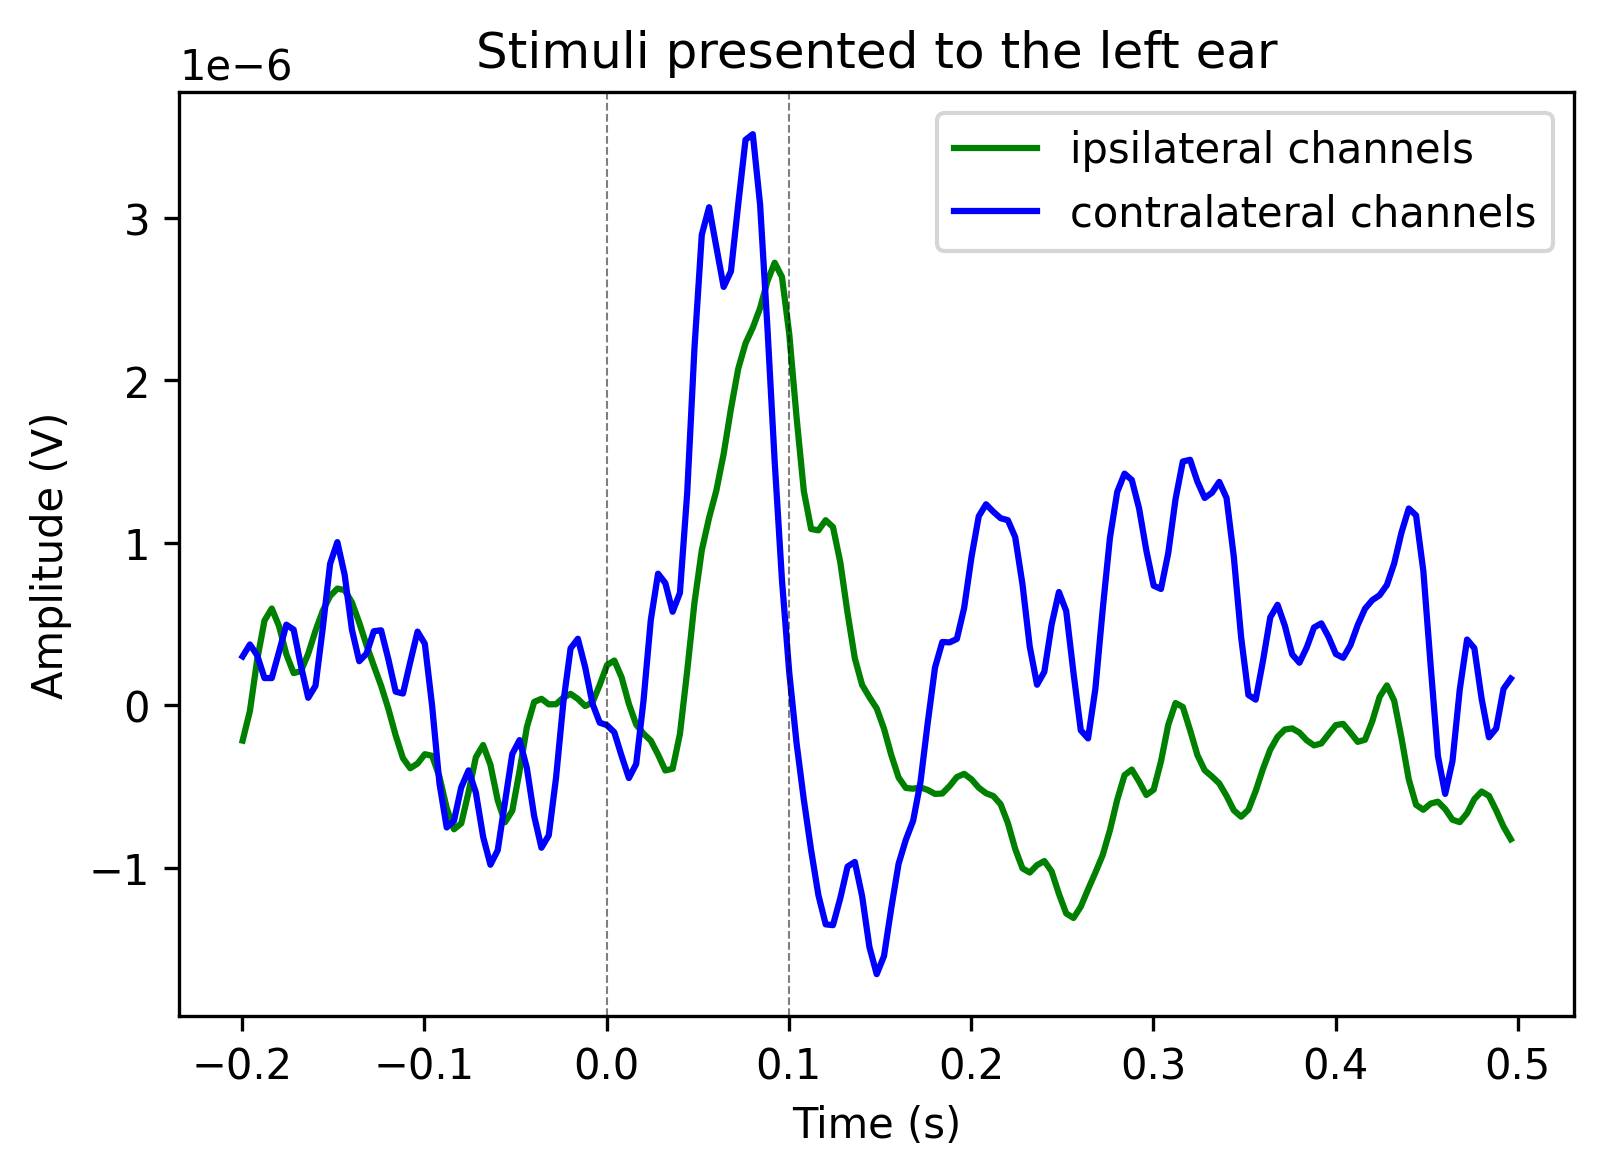

In [113]:
contra_ipsi_plot(epochs['auditory/left'], contra_ch=['EEG 042', 'EEG 041' 'EEG 035', 'EEG 034'], ipsi_ch=['EEG 026', 'EEG 035', 'EEG 025', 'EEG 039'], title='Stimuli presented to the left ear', timepoints=[0, 0.1])

Do a quick literature search, to identify which channels are considered to pick up activity from the left and right visual fields when using EEG. Then use the function to determine whether **interpretation 2** is correct.

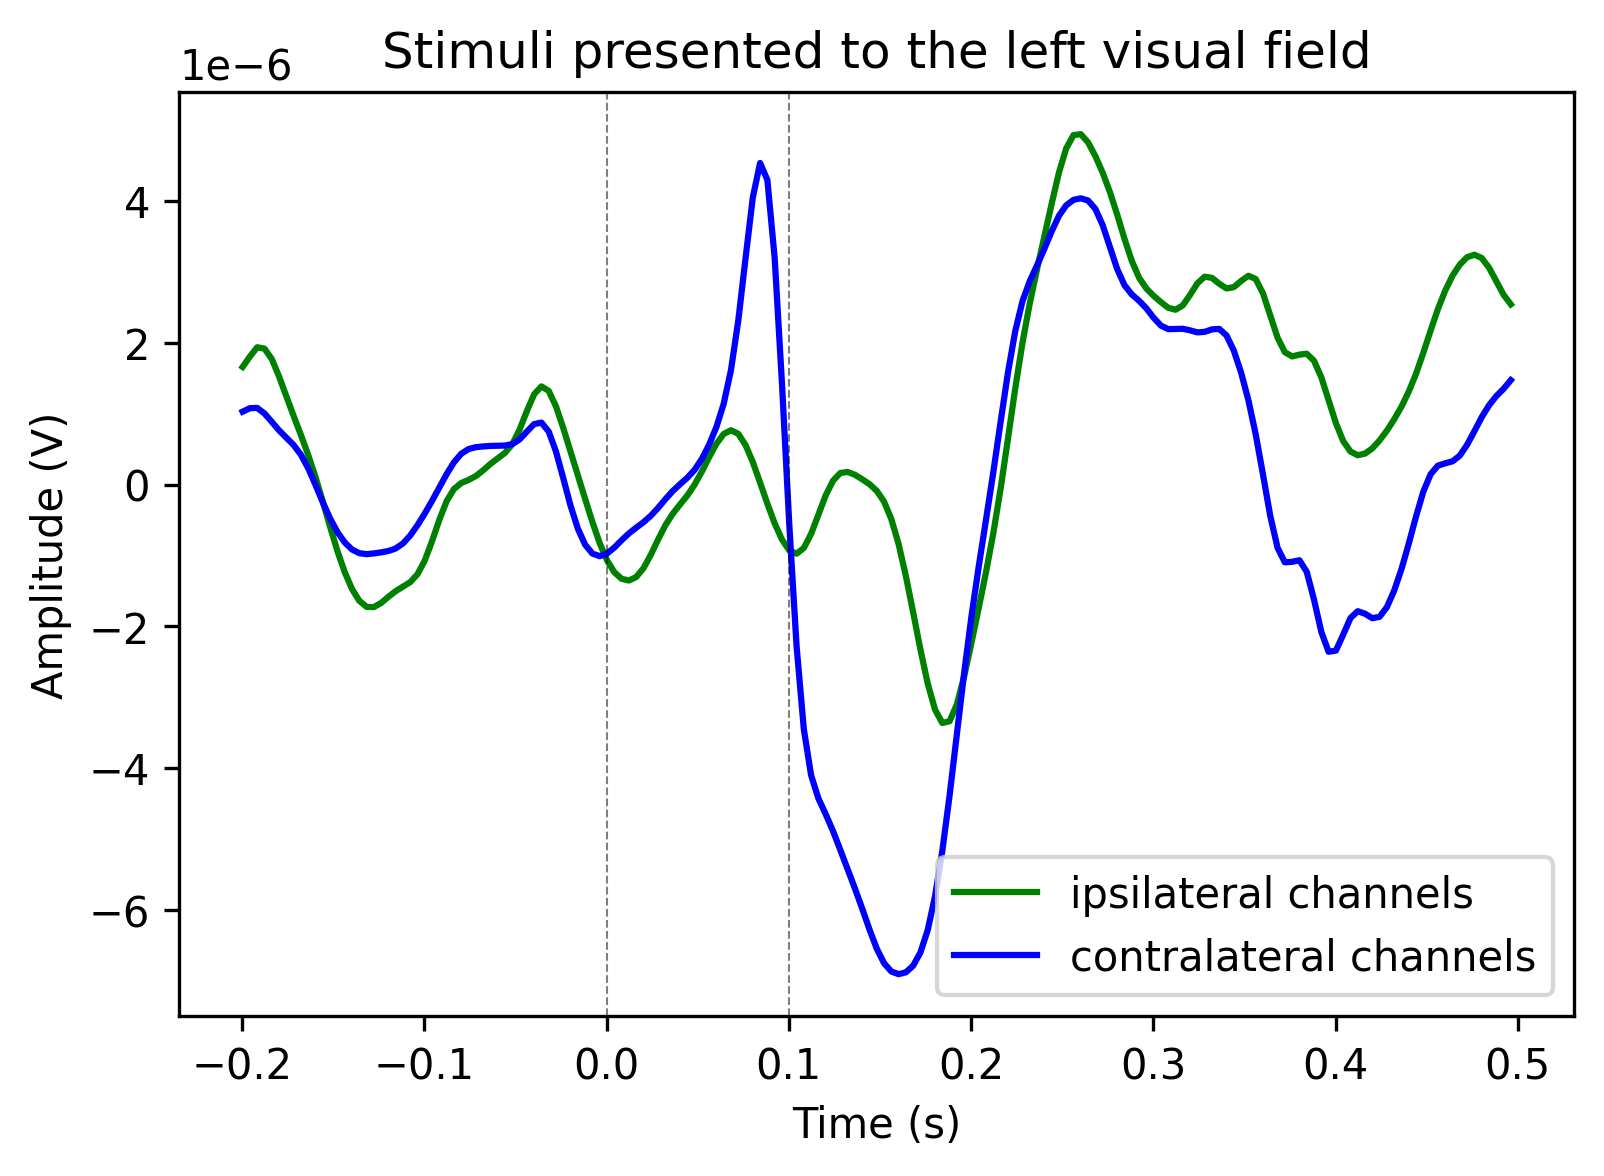

In [114]:
# YOUR CODE GOES HERE!
# DELETE THIS BEFORE POSTING TO GITHUB AND BRIGHTSPACE
contra_ipsi_plot(epochs['visual/left'], contra_ch=['EEG 059', 'EEG 055', 'EEG 049'], ipsi_ch=['EEG 057', 'EEG 054', 'EEG 047'], title='Stimuli presented to the left visual field', timepoints=[0, 0.1])

**Thought exercise:** Was the interpretation correct? Why or why not? 



### Further investigation
Another way to investigate this is to plot the topography of the evoked response for the visual condition for left and right seperately. To do this, you can use the function `mne.viz.plot_topomap`. This function takes as input an evoked object, and plots the topography of the evoked response for each time point you specify. You can use the function mne.combine_evoked to calulate the difference in the evoked response between presentation of stimuli to the left and right visual fields, and then plot the topography of this difference as well. 

In [ ]:
# create evoked objects

# plot the topographies of the evoked responses

# calculate the difference in evoked responses

# plot the topographies of the difference in evoked responses

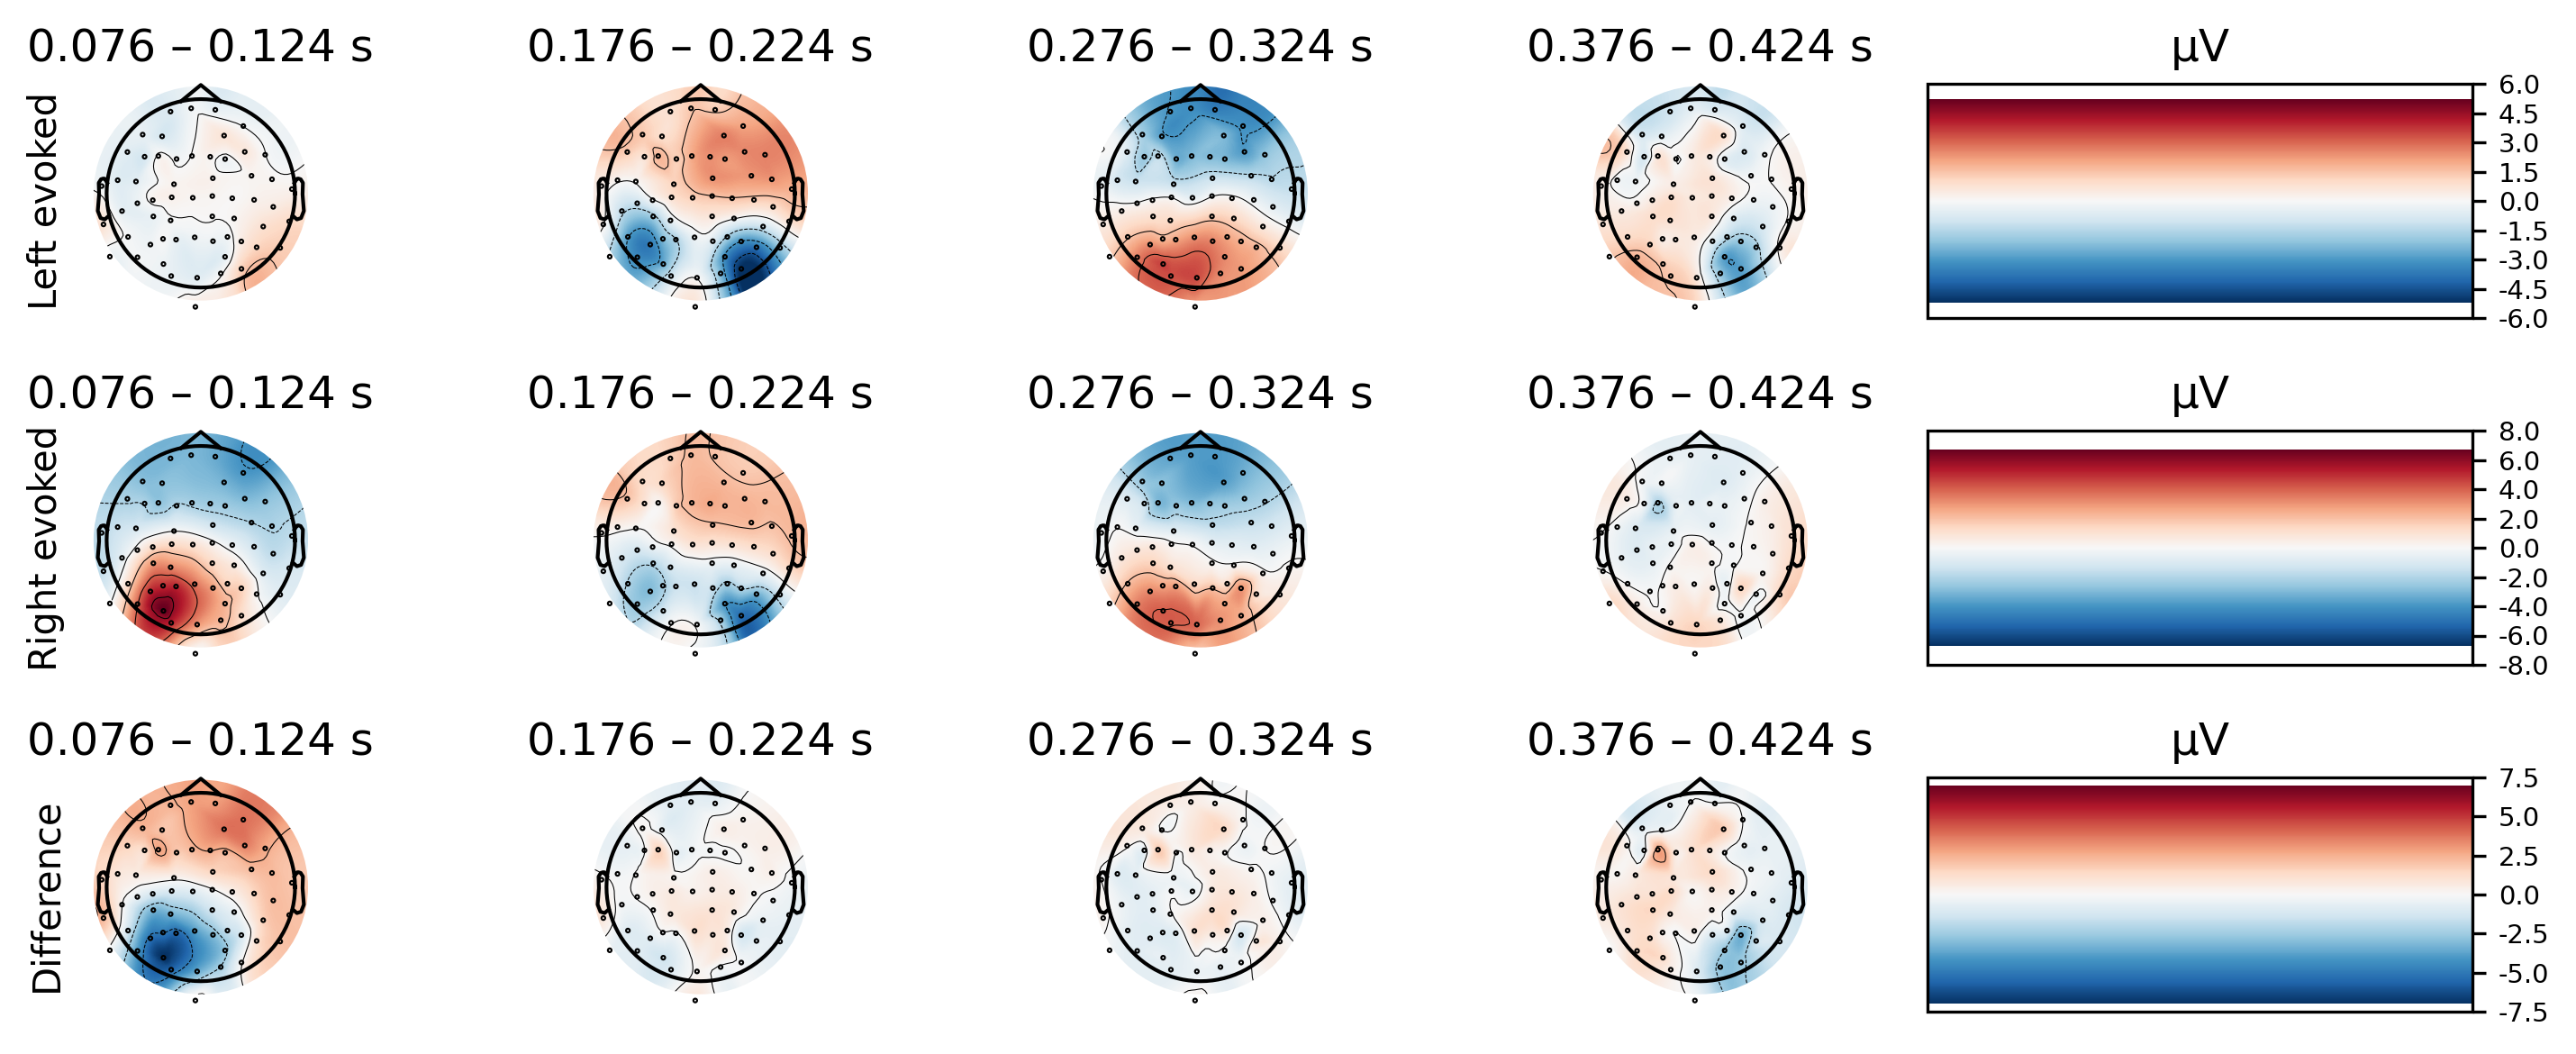

In [115]:
evoked_left = epochs['visual/left'].copy().average()
evoked_right = epochs['visual/right'].copy().average()

# PLOT TOPOGRAPHIES
fig, axes = plt.subplots(3, 5, figsize=(10, 4), dpi=300)
axes[0, 0].set_ylabel("Left evoked")
evoked_left.plot_topomap(times=[0.1, 0.2, 0.3, 0.4], average=0.05, time_unit='s', axes=axes[0], show=False);

axes[1, 0].set_ylabel("Right evoked")
evoked_right.plot_topomap(times=[0.1, 0.2, 0.3, 0.4], average=0.05, time_unit='s', axes=axes[1], show=False);

# difference topography
evoked_dif = mne.combine_evoked([evoked_left, evoked_right], weights=[1, -1])
axes[2, 0].set_ylabel("Difference")
evoked_dif.plot_topomap(times=[0.1, 0.2, 0.3, 0.4], average=0.05, time_unit='s', axes=axes[2], show=False);

plt.tight_layout()


# Interpretation 3